In [12]:
# data manipulations
import numpy as np
import pandas as pd
# progress bar
from tqdm.notebook import tqdm_notebook
# audio analysis
import librosa
# save audio file
import soundfile as sf
# noise reducer
import noisereduce as nr
# standardization
from sklearn.preprocessing import StandardScaler
# serialization of objects
import pickle
# working with directory
import pathlib

In [13]:
# printing results and listening
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa.display

def wave_and_audio(sample, sr):
    # plot the signal
    plt.figure(figsize=(10, 4))
    librosa.display.waveplot(sample, sr=sr)
    plt.title('Waveplot of audio sample')
    plt.show()
    # reproduce the sample
    ipd.display(ipd.Audio(sample, rate=sr))

In [14]:
metadata = pd.read_csv("to_load.csv")
metadata.head()

,path,label,samplingrate,ms
0,./Labelled/Bleatings/evt_000_000_000681_210415...,Bleatings,16000,9751.0
1,./Labelled/Bleatings/evt_000_000_000682_210415...,Bleatings,16000,6190.0
2,./Labelled/Bleatings/evt_000_000_000683_210415...,Bleatings,16000,6072.0
3,./Labelled/Bleatings/evt_000_000_000684_210415...,Bleatings,16000,6106.0
4,./Labelled/Bleatings/evt_000_000_002434_210416...,Bleatings,16000,10264.0


In [15]:
sr = metadata["samplingrate"][0]
sr

16000

In [16]:
paths = metadata["path"]
samples = []
for path in tqdm_notebook(paths):
    sample, sampling_rate = librosa.load(path, sr=None, mono=True)
    samples.append(sample)
samples[:5]

  0%|          | 0/827 [00:00<?, ?it/s]

[array([ 0.01379395,  0.00057983,  0.01922607, ..., -0.01580811,
        -0.01345825, -0.01861572], dtype=float32),
 array([-0.01376343, -0.00183105,  0.00115967, ...,  0.02661133,
         0.02331543,  0.01779175], dtype=float32),
 array([-2.3986816e-02, -9.6130371e-03, -1.3641357e-02, ...,
        -1.0070801e-02,  6.1035156e-05,  4.5776367e-03], dtype=float32),
 array([-0.01174927, -0.00735474, -0.00198364, ..., -0.00079346,
         0.00054932, -0.00073242], dtype=float32),
 array([ 0.05810547,  0.0345459 ,  0.0211792 , ..., -0.07623291,
         0.03268433,  0.13360596], dtype=float32)]

# Data augmentation

The dataset is pretty imbalanced so we can balance the total duration of the samples by mean of data augmentation as presented in analysis.ipybn<br>Further to balancing the dataser I decided also to incerase the samples for each class in order to increase the model capability of generalization.

In [17]:
def time_stretch_sample(sample, factors):
    stretched = []
    for f in factors:
        stretched.append(librosa.effects.time_stretch(sample, f))
    return stretched

def pitch_shift_sample(sample, factors, sr):
    stretched = []
    for f in factors:
        stretched.append(librosa.effects.pitch_shift(sample, sr, f))
    return stretched

time_factors = [0.81, 0.93, 1.07, 1.23]
pitch_factors = [-3, -1-5, +1-5, +3]

Bleaetings is the class with more samples with a duration of 4814 seconds. I decided to obtain a total duration for each class of at least 7000 seconds

In [18]:
def return_type(df, label):
    condition = df["label"]==label
    elements = df[condition]
    return elements

metadata.insert(len(metadata.columns), 'mod', 0)

bleatings = return_type(metadata, "Bleatings")
contactcalls = return_type(metadata, "ContactCalls")
others = return_type(metadata, "Others")

In [19]:
others.head()

,path,label,samplingrate,ms,mod
426,./Labelled/Others/evt_000_000_000388_210415_13...,Others,16000,12060.0,0
427,./Labelled/Others/evt_000_000_001500_210415_22...,Others,16000,6091.0,0
428,./Labelled/Others/evt_000_000_003856_210416_21...,Others,16000,6055.0,0
429,./Labelled/Others/evt_000_000_008803_210419_12...,Others,16000,12575.0,0
430,./Labelled/Others/evt_000_000_010313_210420_01...,Others,16000,6209.0,0


We augment the data by picking random records (only once) and apply at random one of the two transformations

In [20]:
def augment_data(metadata, samples, time_f, pitch_f):
    metadata = metadata.copy()
    extended_samples = []
    new_metadata = []
    tot_duration = np.sum(metadata["ms"])
    while tot_duration < 7000000:
        # get a random non taken sample
        not_picked = metadata[metadata["mod"]==0]
        choosen = not_picked.sample()
        idx = choosen.index[0]
        sample = samples[idx]
        
        # get values
        choosen = choosen.values[0]
        path = choosen[0]
        label = choosen[1]
        sr = choosen[2]
        
        # update metadata locally
        metadata.loc[idx]["mod"] = 1
        
        # choose at random the transformation: 1 time, 2 pitch
        choose = np.random.randint(1,3)
        mod_samples = time_stretch_sample(sample, time_f) if choose==1 else pitch_shift_sample(sample, pitch_f, sr)
        
        # extract the metadata
        mod_metadata = [(path, label, sr, 1000*len(s)/sr, choose) for s in mod_samples]
        
        # add modified samples and metadata to the list
        extended_samples += mod_samples
        new_metadata += mod_metadata
        
        # update tot duration
        tot_duration += np.sum([1000*len(s)/sr for s in mod_samples])
    
    #new_metadata = pd.DataFrame(new_metadata, columns=["path","label","samplingrate","ms","mod"])
    return extended_samples, new_metadata

In [21]:
to_do = [bleatings, contactcalls, others]

extended_samples = []
extended_metadata = []

for category in tqdm_notebook(to_do):
    new_samples, new_metadata = augment_data(category, samples, time_factors, pitch_factors)
    extended_samples += new_samples
    extended_metadata += new_metadata

  0%|          | 0/3 [00:00<?, ?it/s]

C:\Users\Nicolas Facchinetti\.conda\envs\progapr\lib\site-packages\pandas\core\series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()
C:\Users\Nicolas Facchinetti\.conda\envs\progapr\lib\site-packages\pandas\core\series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()


In [22]:
extended_metadata_df = pd.DataFrame(extended_metadata, columns=["path","label","samplingrate","ms","mod"])
extended_metadata_df.head()

,path,label,samplingrate,ms,mod
0,./Labelled/Bleatings/evt_000_000_025463_210427...,Bleatings,16000,10849.3750,1
1,./Labelled/Bleatings/evt_000_000_025463_210427...,Bleatings,16000,9449.4375,1
2,./Labelled/Bleatings/evt_000_000_025463_210427...,Bleatings,16000,8213.0625,1
3,./Labelled/Bleatings/evt_000_000_025463_210427...,Bleatings,16000,7144.6875,1
4,./Labelled/Bleatings/evt_000_000_025461_210427...,Bleatings,16000,6144.0000,2


In [23]:
metadata_extended = metadata.append(extended_metadata_df, ignore_index=True)
samples += extended_samples
metadata_extended

,path,label,samplingrate,ms,mod
0,./Labelled/Bleatings/evt_000_000_000681_210415...,Bleatings,16000,9751.0000,0
1,./Labelled/Bleatings/evt_000_000_000682_210415...,Bleatings,16000,6190.0000,0
2,./Labelled/Bleatings/evt_000_000_000683_210415...,Bleatings,16000,6072.0000,0
3,./Labelled/Bleatings/evt_000_000_000684_210415...,Bleatings,16000,6106.0000,0
4,./Labelled/Bleatings/evt_000_000_002434_210416...,Bleatings,16000,10264.0000,0
...,...,...,...,...,...
1422,./Labelled/Others/evt_001_003_009083_210421_07...,Others,16000,6051.2500,1
1423,./Labelled/Others/evt_001_004_018578_210425_15...,Others,16000,7442.0000,1
1424,./Labelled/Others/evt_001_004_018578_210425_15...,Others,16000,6481.7500,1
1425,./Labelled/Others/evt_001_004_018578_210425_15...,Others,16000,5633.6250,1


In [24]:
len(samples)

1427

In [25]:
def return_total_time(df, label):
    condition = df["label"]==label
    elements = df[condition]
    time = elements["ms"]
    return np.sum(time)

tot_times = {"Bleatings": return_total_time(metadata_extended, "Bleatings"),
            "ContactCalls": return_total_time(metadata_extended, "ContactCalls"),
             "Others": return_total_time(metadata_extended, "Others")}
tot_times = pd.DataFrame.from_dict(tot_times, orient='index', columns=["Tot ms"])
tot_times.astype(str)

,Tot ms
Bleatings,7044872.25
ContactCalls,7025154.25
Others,7020512.9375


# Preprocessing

## Segment the long sample

Let's break all the sample above of 3 seconds in subsample with a window 3 of seconds and hop size 1.5 seconds 

In [26]:
max_len = 3
condition = metadata_extended["ms"] > max_len*1000
long = metadata_extended[condition]
len(long)

1427

All the samples must be splitted

In [27]:
def split_in_equal(sample, sr, maxd):
    buffer = maxd * sr
    # step = maxd/2
    step = maxd
    samples_total = len(sample)
    samples_wrote = 0
    next_buffer = 0


    splitted_sample = []

    while samples_wrote < samples_total:
        #check if the buffer is not exceeding total samples 
        if buffer > (samples_total - next_buffer):
            buffer = samples_total - next_buffer

        end = next_buffer + buffer
        block = sample[next_buffer : end]
        splitted_sample.append(block)
        
        next_buffer = next_buffer + int(step * sr)
        
        buffer = maxd*sr
        samples_wrote = end
    return splitted_sample

In [28]:
metadata_extended.head()

,path,label,samplingrate,ms,mod
0,./Labelled/Bleatings/evt_000_000_000681_210415...,Bleatings,16000,9751.0,0
1,./Labelled/Bleatings/evt_000_000_000682_210415...,Bleatings,16000,6190.0,0
2,./Labelled/Bleatings/evt_000_000_000683_210415...,Bleatings,16000,6072.0,0
3,./Labelled/Bleatings/evt_000_000_000684_210415...,Bleatings,16000,6106.0,0
4,./Labelled/Bleatings/evt_000_000_002434_210416...,Bleatings,16000,10264.0,0


In [29]:
split_samples = []
split_metadata = []
for c, sample in enumerate(tqdm_notebook(samples)):
    if metadata_extended.iloc[c]["ms"] > max_len*1000:
        splitted_sample = split_in_equal(sample, sr, max_len)
        split_samples += splitted_sample
        new_metadata = [[metadata_extended.iloc[c]["path"],
                         i,
                         metadata_extended.iloc[c]["label"],
                         sr,
                         1000*len(s)/sr,
                         metadata_extended.iloc[c]["mod"]]
                         for i, s in enumerate(splitted_sample)]
        split_metadata += new_metadata

split_metadata = pd.DataFrame(split_metadata, columns=["path", "segment", "label", "samplingrate", "ms", "mod"])
split_metadata

  0%|          | 0/1427 [00:00<?, ?it/s]

,path,segment,label,samplingrate,ms,mod
0,./Labelled/Bleatings/evt_000_000_000681_210415...,0,Bleatings,16000,3000.0000,0
1,./Labelled/Bleatings/evt_000_000_000681_210415...,1,Bleatings,16000,3000.0000,0
2,./Labelled/Bleatings/evt_000_000_000681_210415...,2,Bleatings,16000,3000.0000,0
3,./Labelled/Bleatings/evt_000_000_000681_210415...,3,Bleatings,16000,751.0000,0
4,./Labelled/Bleatings/evt_000_000_000682_210415...,0,Bleatings,16000,3000.0000,0
...,...,...,...,...,...,...
7897,./Labelled/Others/evt_001_004_018578_210425_15...,2,Others,16000,481.7500,1
7898,./Labelled/Others/evt_001_004_018578_210425_15...,0,Others,16000,3000.0000,1
7899,./Labelled/Others/evt_001_004_018578_210425_15...,1,Others,16000,2633.6250,1
7900,./Labelled/Others/evt_001_004_018578_210425_15...,0,Others,16000,3000.0000,1


We obtained a total of 7926 samples from the agumented set of 1455 records. Let's have a look at the ditrbituion of the class

In [30]:
count_label = split_metadata['label'].value_counts().to_frame()
count_label

,label
Others,2767
Bleatings,2647
ContactCalls,2488


Also the dataset is balanced!

## Denoising and trimming

Let's remove the noise from the samples and then trim the silent part at the beggining and ending of the samples.

In [31]:
denoise_trim_samples = []

for count, sample in enumerate(tqdm_notebook(split_samples)):
    if split_metadata.iloc[count]["label"] != "Others":
        sample = nr.reduce_noise(y=sample, sr=sr, use_tqdm=False)
    sample = librosa.effects.trim(sample, top_db=15, frame_length=512, hop_length=64)[0]
    denoise_trim_samples.append(sample)
denoise_trim_samples[:5]

  0%|          | 0/7902 [00:00<?, ?it/s]

[array([-0.02437842, -0.02365888, -0.00902225, ..., -0.00756735,
        -0.00464633, -0.0001669 ], dtype=float32),
 array([ 0.0124789 ,  0.01066994,  0.0083406 , ..., -0.0032531 ,
         0.0044106 ,  0.00692406], dtype=float32),
 array([-1.03670144e-02, -7.80101586e-03, -2.67368346e-03, ...,
         7.08722582e-05, -1.04012266e-04, -2.75029871e-03], dtype=float32),
 array([ 0.00598434,  0.00422857,  0.00194617, ..., -0.00959768,
        -0.00781307, -0.01161874], dtype=float32),
 array([-0.02457678, -0.00897858, -0.00589399, ...,  0.00259352,
         0.00390261,  0.00921702], dtype=float32)]

In [32]:
metadata_clean = []
for sample in tqdm_notebook(denoise_trim_samples):
    nframe = len(sample)
    length = 1000*nframe/sr
    metadata_clean.append([length])

split_metadata_trim = pd.concat([split_metadata, pd.DataFrame(metadata_clean, columns = ["ms_trim"])], axis=1)
split_metadata_trim.head()

  0%|          | 0/7902 [00:00<?, ?it/s]

,path,segment,label,samplingrate,ms,mod,ms_trim
0,./Labelled/Bleatings/evt_000_000_000681_210415...,0,Bleatings,16000,3000.0,0,1920.0
1,./Labelled/Bleatings/evt_000_000_000681_210415...,1,Bleatings,16000,3000.0,0,2180.0
2,./Labelled/Bleatings/evt_000_000_000681_210415...,2,Bleatings,16000,3000.0,0,2988.0
3,./Labelled/Bleatings/evt_000_000_000681_210415...,3,Bleatings,16000,751.0,0,751.0
4,./Labelled/Bleatings/evt_000_000_000682_210415...,0,Bleatings,16000,3000.0,0,2404.0


count    7902.000000
mean     2055.663013
std       992.909545
min         6.000000
25%      1264.000000
50%      2436.000000
75%      2980.000000
max      3000.000000
Name: ms_trim, dtype: float64

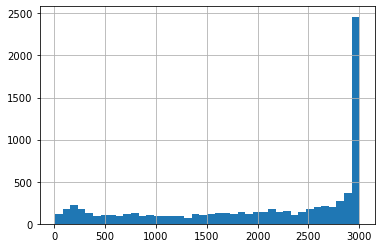

In [33]:
durations = split_metadata_trim['ms_trim']
durations.hist(bins=40)
durations.describe()

# Remove short samples

In [34]:
condition = split_metadata_trim["ms_trim"] > 500
split_metadata_trim = split_metadata_trim[condition]

condition.value_counts()

True     6944
False     958
Name: ms_trim, dtype: int64

In [35]:
processed_samples = [sample for count, sample in enumerate(denoise_trim_samples) if condition[count]==True]
len(processed_samples)

6944

In [36]:
split_metadata_trim

,path,segment,label,samplingrate,ms,mod,ms_trim
0,./Labelled/Bleatings/evt_000_000_000681_210415...,0,Bleatings,16000,3000.0000,0,1920.0000
1,./Labelled/Bleatings/evt_000_000_000681_210415...,1,Bleatings,16000,3000.0000,0,2180.0000
2,./Labelled/Bleatings/evt_000_000_000681_210415...,2,Bleatings,16000,3000.0000,0,2988.0000
3,./Labelled/Bleatings/evt_000_000_000681_210415...,3,Bleatings,16000,751.0000,0,751.0000
4,./Labelled/Bleatings/evt_000_000_000682_210415...,0,Bleatings,16000,3000.0000,0,2404.0000
...,...,...,...,...,...,...,...
7896,./Labelled/Others/evt_001_004_018578_210425_15...,1,Others,16000,3000.0000,1,3000.0000
7898,./Labelled/Others/evt_001_004_018578_210425_15...,0,Others,16000,3000.0000,1,2796.0000
7899,./Labelled/Others/evt_001_004_018578_210425_15...,1,Others,16000,2633.6250,1,2633.6250
7900,./Labelled/Others/evt_001_004_018578_210425_15...,0,Others,16000,3000.0000,1,2856.0000


In [37]:
count_label = split_metadata_trim['label'].value_counts().to_frame()
count_label

,label
Others,2465
Bleatings,2323
ContactCalls,2156


## Pad the short samples

Finally we can pad all the samples to the same lenght.<br>The max duration is 3000ms, which is 3 seconds. Let's pad all the shorter samples to this lenght by centering the sample in the middle of signal.

In [38]:
def zero_pad_data(sample, sr, length):
    """
    sample: audio sample
    sr: sample rate
    lenght: length to reach
    """
    # find lenght according to sr
    length = sr*length
    
    signal_padded = np.zeros(length)
    
    sample_len = len(sample)
    start = int(length/2) - int(sample_len/2)
    signal_padded[start: start+sample_len] = sample
    return signal_padded

processed_samples = [zero_pad_data(sample, sr, 3) for sample in processed_samples]

In [39]:
processed_metadata = split_metadata_trim[["path", "segment", "mod", "label", "samplingrate"]]

processed_metadata["ms"] = [1000*len(sample)/sr for sample in processed_samples]
#length_info = [1000*len(sample)/sr for sample in processed_samples]

#processed_metadata = pd.concat([processed_metadata, pd.DataFrame(length_info, columns = ["ms"])], axis=1, ignore_index=True)
processed_metadata['ms'].describe()

C:\Users\NICOLA~1\AppData\Local\Temp/ipykernel_2904/2139854715.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processed_metadata["ms"] = [1000*len(sample)/sr for sample in processed_samples]


count    6944.0
mean     3000.0
std         0.0
min      3000.0
25%      3000.0
50%      3000.0
75%      3000.0
max      3000.0
Name: ms, dtype: float64

# Save processed samples and metadata

Export the processed sample in 16 bit .wav file to fed them to YAMN net later.

In [41]:
pathlib.Path(f'processed_samples').mkdir(parents=True, exist_ok=True)
filenames = []
for count, sample in enumerate(tqdm_notebook(processed_samples)):
    # sample_info = processed_metadata.iloc[count]
    # filename = f'{count}_{sample_info["path"].replace("/", "_")}_mod{sample_info["mod"]}_seg{sample_info["segment"]}'
    filename = f'processed_samples/{count}.wav'
    sf.write(filename, sample, sr, subtype='PCM_16')
    filenames.append(filename)

processed_metadata["samples"] = filenames

  0%|          | 0/6944 [00:00<?, ?it/s]

Save the metada to .cvs file

In [42]:
processed_metadata.to_csv("processed_metadata.csv", index=False)
processed_metadata

,path,segment,mod,label,samplingrate,ms,samples
0,./Labelled/Bleatings/evt_000_000_000681_210415...,0,0,Bleatings,16000,3000.0,processed_samples/0.wav
1,./Labelled/Bleatings/evt_000_000_000681_210415...,1,0,Bleatings,16000,3000.0,processed_samples/1.wav
2,./Labelled/Bleatings/evt_000_000_000681_210415...,2,0,Bleatings,16000,3000.0,processed_samples/2.wav
3,./Labelled/Bleatings/evt_000_000_000681_210415...,3,0,Bleatings,16000,3000.0,processed_samples/3.wav
4,./Labelled/Bleatings/evt_000_000_000682_210415...,0,0,Bleatings,16000,3000.0,processed_samples/4.wav
...,...,...,...,...,...,...,...
7896,./Labelled/Others/evt_001_004_018578_210425_15...,1,1,Others,16000,3000.0,processed_samples/6939.wav
7898,./Labelled/Others/evt_001_004_018578_210425_15...,0,1,Others,16000,3000.0,processed_samples/6940.wav
7899,./Labelled/Others/evt_001_004_018578_210425_15...,1,1,Others,16000,3000.0,processed_samples/6941.wav
7900,./Labelled/Others/evt_001_004_018578_210425_15...,0,1,Others,16000,3000.0,processed_samples/6942.wav


# Features extraction

## Log Mel-spectograms

We can compute the log mel-spectrogram of each sample, with 128 mel bands

In [43]:
logmelspectrograms = []
for sample in tqdm_notebook(processed_samples):
    S = librosa.feature.melspectrogram(y=sample, sr=sr, n_mels=128)
    S_dB = librosa.power_to_db(S, ref=np.max)
    logmelspectrograms.append(S_dB)

  0%|          | 0/6944 [00:00<?, ?it/s]

In [44]:
a, b, c = np.shape(logmelspectrograms)
print(f'A total of {a} samples, with {b} mel bands and {c} samples')

A total of 6944 samples, with 128 mel bands and 94 samples


Save the result for further processing

In [45]:
pickle.dump(logmelspectrograms, open("logmelspectrograms_data.p", "wb"))

## Spectrograms Images

In [46]:
logmelspectrograms = pickle.load(open("logmelspectrograms_data.p", "rb" ))
processed_metadata = pd.read_csv("processed_metadata.csv")
processed_metadata.head()

,path,segment,mod,label,samplingrate,ms,samples
0,./Labelled/Bleatings/evt_000_000_000681_210415...,0,0,Bleatings,16000,3000.0,processed_samples/0.wav
1,./Labelled/Bleatings/evt_000_000_000681_210415...,1,0,Bleatings,16000,3000.0,processed_samples/1.wav
2,./Labelled/Bleatings/evt_000_000_000681_210415...,2,0,Bleatings,16000,3000.0,processed_samples/2.wav
3,./Labelled/Bleatings/evt_000_000_000681_210415...,3,0,Bleatings,16000,3000.0,processed_samples/3.wav
4,./Labelled/Bleatings/evt_000_000_000682_210415...,0,0,Bleatings,16000,3000.0,processed_samples/4.wav


Next we can take the previous obtained list of log mel-scaled spectrogram and finally convert them to images and save to a folder img_data.

In [47]:
image_metadata = []

for g in "Bleatings ContactCalls Others".split():
    pathlib.Path(f'img_data/{g}').mkdir(parents=True, exist_ok=True)

for count, sample in enumerate(tqdm_notebook(logmelspectrograms)):
    # label and filename
    label = processed_metadata.iloc[count]["label"]
    filename = f'img_data/{label}/{count}.png'
    # save image to local drive
    img = librosa.display.specshow(sample, sr=sr)
    plt.savefig(filename)
    plt.clf()
    # append to image metadata
    image_metadata.append([filename, label])

  0%|          | 0/6944 [00:00<?, ?it/s]

<Figure size 432x288 with 0 Axes>

Save the metadata about images

In [48]:
image_metadata_df = pd.DataFrame(image_metadata, columns=["Path", "Label"])
image_metadata_df.head()

,Path,Label
0,img_data/Bleatings/0.png,Bleatings
1,img_data/Bleatings/1.png,Bleatings
2,img_data/Bleatings/2.png,Bleatings
3,img_data/Bleatings/3.png,Bleatings
4,img_data/Bleatings/4.png,Bleatings


In [49]:
image_metadata_df.to_csv("image_metadata.csv", index=False)

## Features MFCC and Delta-MFCC

Let's extract as presented in analysis.ipybn the MFCC and delta-MFCC realted features

In [50]:
features_long = []
features_resumed = []
for sample in tqdm_notebook(processed_samples):
    mfccs = librosa.feature.mfcc(sample, sr = sr, n_mfcc=13)
    mfccs_trunc = np.hstack((np.mean(mfccs, axis=1), np.std(mfccs, axis=1), np.max(mfccs, axis = 1),
                             np.median(mfccs, axis = 1), np.min(mfccs, axis = 1)))
    mfccs_delta = librosa.feature.delta(mfccs, mode='nearest')
    mfccs_delta_trunc = np.hstack((np.mean(mfccs_delta, axis=1), np.std(mfccs_delta, axis=1), np.max(mfccs_delta, axis = 1),
                                   np.median(mfccs_delta, axis = 1), np.min(mfccs_delta, axis = 1)))
    features_resumed.append(np.concatenate((mfccs_trunc, mfccs_delta_trunc)))
    features_long.append(np.concatenate((mfccs.flatten(), mfccs_delta.flatten())))

print(np.shape(features_resumed))

print(np.shape(features_long))

  0%|          | 0/6944 [00:00<?, ?it/s]

(6944, 130)
(6944, 2444)


Save the obtained result to a .cvs file for processing with the models.

In [52]:
df1 = pd.DataFrame(features_resumed)
df2 = pd.DataFrame(features_long)
df1.to_csv("mfcc_deltamfcc_stat.csv", index=False)
df2.to_csv("mfcc_deltamfcc_entire.csv", index=False)